In [45]:
import torch
import torchvision
from torch.utils.data import DataLoader
print(torchvision.__version__)

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  return correct/len(y_pred)*100

0.20.0+cu121


In [46]:
# Continue with regular imports
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [47]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [48]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists.


In [49]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

BATCH_SIZE = 16

#Datasets and dataloaders

In [50]:
data_transform_train = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

data_transform_test = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

train_data = torchvision.datasets.ImageFolder(train_dir, transform=manual_transforms)
test_data = torchvision.datasets.ImageFolder(test_dir, transform=data_transform_test)

classes = train_data.classes

train_data, test_data, classes

(Dataset ImageFolder
     Number of datapoints: 450
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset ImageFolder
     Number of datapoints: 150
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 ['pizza', 'steak', 'sushi'])

#Automatic transforms

In [51]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [52]:
# Transform
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [53]:
#train_data = torchvision.datasets.ImageFolder(train_dir, transform=auto_transform)
#test_data = torchvision.datasets.ImageFolder(test_dir, transform=auto_transform)

BATCH_SIZE = 16

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())

classes = train_data.classes

train_data, test_data, classes

(Dataset ImageFolder
     Number of datapoints: 450
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset ImageFolder
     Number of datapoints: 150
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 ['pizza', 'steak', 'sushi'])

# Model EfficientNet

In [54]:
model = torchvision.models.efficientnet_b0(weights=weights)

In [55]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [56]:
from torchinfo import summary

summary(model=model, input_size = (1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

# Freezing model

In [57]:
for param in model.features.parameters():
  param.requires_grad = False

In [58]:
summary(model=model, input_size = (1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

# Update head

In [59]:
model.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True), nn.Linear(1280, 3))

In [60]:
summary(model=model, input_size = (1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

# Train

In [61]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [62]:
from tqdm.auto import tqdm
import time

train_losses = []
test_losses = []
test_accuracies = []

In [63]:
epochs = 50
program_starts = time.time()
for epoch in tqdm(range(epochs)):
  train_loss = 0
  for batch, (X, y) in enumerate(train_dataloader):
    model.train()
    X=X.to(device)
    y=y.to(device)
    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    #if batch%5 == 0:
      #print(f"Batch: {batch}/{len(train_dataloader)}")

  train_loss /= len(train_dataloader)
  train_losses.append(train_loss.cpu().detach().numpy())

  model.eval()
  test_loss = 0
  test_accuracy = 0
  with torch.inference_mode():
    for X, y in test_dataloader:
      X=X.to(device)
      y=y.to(device)
      test_pred = model(X)

      test_loss += loss_fn(test_pred, y)
      test_accuracy += accuracy_fn(y, test_pred.argmax(dim=1))


    test_loss /= len(test_dataloader)
    test_losses.append(test_loss.cpu())

    test_accuracy /= len(test_dataloader)
    test_accuracies.append(test_accuracy)

  print(f"Epoch: {epoch+1} | Loss: {train_loss} | Test acc: {test_accuracy}%")


program_ends = time.time()

print(f"Elapsed: {program_ends-program_starts}s")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | Loss: 0.9053854942321777 | Test acc: 84.16666666666666%
Epoch: 2 | Loss: 0.660858690738678 | Test acc: 94.375%
Epoch: 3 | Loss: 0.5674132704734802 | Test acc: 92.29166666666666%
Epoch: 4 | Loss: 0.4580588936805725 | Test acc: 92.91666666666666%
Epoch: 5 | Loss: 0.47288191318511963 | Test acc: 92.08333333333334%
Epoch: 6 | Loss: 0.4557837247848511 | Test acc: 95.20833333333334%
Epoch: 7 | Loss: 0.39559319615364075 | Test acc: 95.625%
Epoch: 8 | Loss: 0.3689897358417511 | Test acc: 95.0%
Epoch: 9 | Loss: 0.3632812798023224 | Test acc: 95.625%
Epoch: 10 | Loss: 0.3702070713043213 | Test acc: 92.70833333333334%
Epoch: 11 | Loss: 0.40576881170272827 | Test acc: 93.33333333333334%
Epoch: 12 | Loss: 0.3339325487613678 | Test acc: 95.20833333333334%
Epoch: 13 | Loss: 0.3115885853767395 | Test acc: 95.625%
Epoch: 14 | Loss: 0.3407413065433502 | Test acc: 95.20833333333334%
Epoch: 15 | Loss: 0.3194945454597473 | Test acc: 95.625%
Epoch: 16 | Loss: 0.3035998046398163 | Test acc: 95.0%


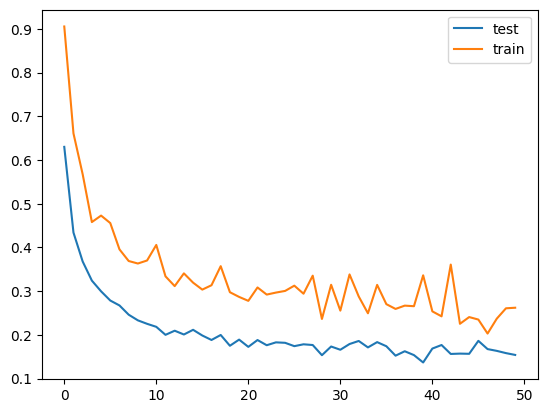

In [64]:
plt.plot(test_losses, label="test")
plt.plot(train_losses, label="train")
plt.legend()
plt.show()

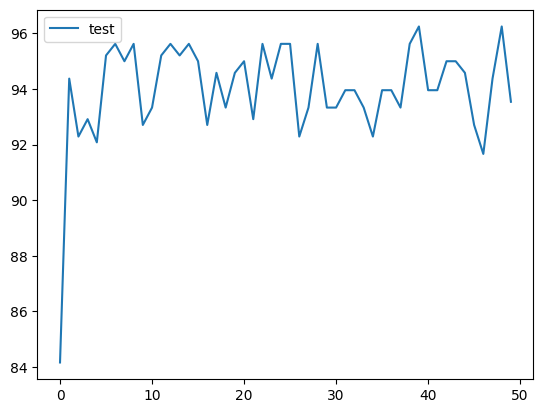

In [65]:
#plt.plot(train_accuracies, label="train")
plt.plot(test_accuracies, label="test")
plt.legend()
plt.show()

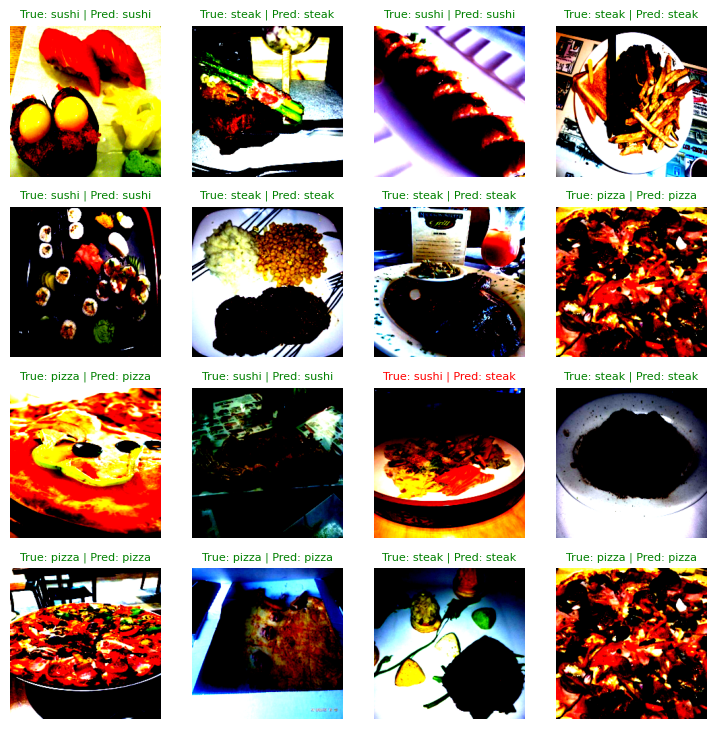

In [66]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(test_data), size=[1]).item()
  image, true_label = test_data[random_idx]

  predicted_label = model(image.unsqueeze(dim=0).to(device)).argmax(dim=1)

  fig.add_subplot(rows, cols, i)
  plt.imshow(image.permute(1, 2, 0), cmap="gray")
  if true_label == predicted_label:
    color = "g"
  else:
    color = "r"
  plt.title(f"True: {classes[true_label]} | Pred: {classes[predicted_label]}", fontsize=8, c=color)
  plt.axis(False)

In [67]:
import numpy as np
import pandas as pd

matrix = np.zeros((3, 3))

y_preds = []

for i in tqdm(range(len(test_data))):
  image, true_label = test_data[i]
  predicted_label = model(image.unsqueeze(dim=0).to(device)).argmax(dim=1)
  y_preds.append(predicted_label)
  matrix[true_label, predicted_label] += 1

df = pd.DataFrame(matrix, index=classes, columns=classes)

df_display = df.copy()
df_display.columns = pd.MultiIndex.from_product([["Predicted"], df.columns])
df_display.index = pd.MultiIndex.from_product([["True"], df.index])
df_display

  0%|          | 0/150 [00:00<?, ?it/s]

Predicted            
               pizza steak sushi
True pizza      45.0   0.0   1.0
     steak       0.0  57.0   1.0
     sushi       1.0   4.0  41.0

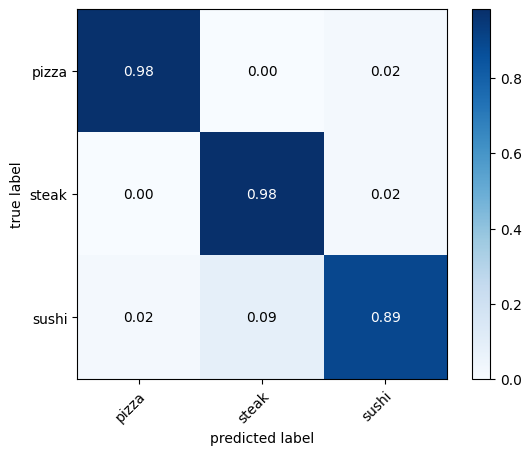

In [68]:
try:
  from torchmetrics import ConfusionMatrix
except:
  !pip install torchmetrics
  from torchmetrics import ConfusionMatrix

try:
  from mlxtend.plotting import plot_confusion_matrix
except:
  !pip install mlxtend
  from mlxtend.plotting import plot_confusion_matrix

y_preds = torch.tensor(y_preds).squeeze()

true_labels = test_data.targets

confmat = ConfusionMatrix(task="multiclass", num_classes=3)
matrix = np.array(confmat(y_preds, torch.tensor(true_labels)))

fig, ax = plot_confusion_matrix(conf_mat=matrix, colorbar=True, show_absolute=False, show_normed=True, class_names=classes)
plt.show()